id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Numerical data: ['age', 'avg_glucose_level', 'bmi']
Categorical data: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Number transactions X_train dataset:  (7777, 10)
Number transactions y_train dataset:  (7777,)
Number transactions X_test dataset:  (1945, 10)
Number transactions y_test dataset:  (1945,)
After OverSampling, the shape o

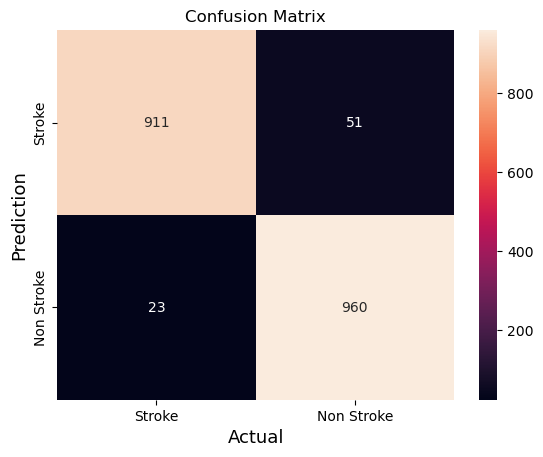

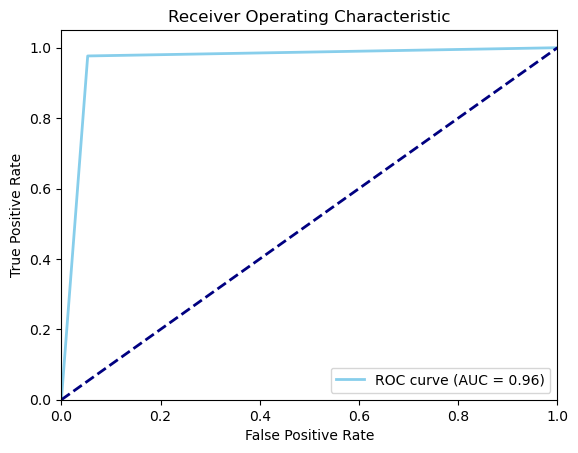

In [18]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import pandas as pd 
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, roc_curve, auc

from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA



# Load the stroke dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

 # Check for missing values in the dataset
print(df.isnull().sum())

# Create a copy of the dataset to store interpolated values
df_interp = df.copy()

# Iterate over columns in the dataset
for col in df.columns:
    # Find indices where values are missing
    missing = df[col].isnull()
    
    if missing.sum() > 0:
        # Create an interpolation function
        f = interp1d(df[col][~missing].index, df[col][~missing].values, kind='cubic')
        
        # Use the interpolation function to fill in missing values
        df_interp.loc[missing, col] = f(df[col][missing].index)
        
# Check for missing values in the interpolated dataset
print(df_interp.isnull().sum())


df_interp.drop('id',axis= 1,inplace= True)

numeric_data=df_interp.loc[:,df_interp.nunique() > 5]
cols = [col for col in df_interp.columns if col not in numeric_data]
categorical_data=df_interp[cols].drop('stroke',axis=1)
numeric_data=pd.DataFrame(numeric_data)
categorical_data=pd.DataFrame(categorical_data)
print(f'Numerical data: {list(numeric_data)}')
print(f'Categorical data: {list(categorical_data)}')


#sstandardization

num_cols=numeric_data.columns.to_list()
sc = StandardScaler()
df_interp[num_cols] = sc.fit_transform(df_interp[num_cols])

#df_interp.head()

#label encoding

le = LabelEncoder()
object_col = [col for col in df_interp.columns if df_interp[col].dtype == 'object']
for col in object_col:
    df_interp[col] = le.fit_transform(df_interp[col])

# Separate features and labels
X = df_interp.drop('stroke', axis=1).values
y = df_interp['stroke'].values

# Apply SMOTE to the training set
sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X,y.ravel())

X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled,test_size=0.20)

#Apply PCA
n_components =9  # Choose the number of components based on your analysis
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print('After OverSampling, the shape of train_X: {}'.format(X_train_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resampled.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_resampled == 0)))





#stack based classifier: base- Random forest, Gradient boosting and Meta-KNN

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the base classifiers
rf_classifier.fit(X_train_pca, y_train)
xgb_classifier.fit(X_train_pca, y_train)

# Generate predictions from base classifiers
rf_pred = rf_classifier.predict(X_train_pca)
gb_pred = xgb_classifier.predict(X_train_pca) 

# Create a new feature matrix containing predictions of base classifiers
X_train_stacked = pd.DataFrame({'RF_Pred': rf_pred, 'GB_Pred': gb_pred})

# Define a meta-classifier (e.g., Logistic Regression)
meta_classifier = KNeighborsClassifier()

# Train the meta-classifier using the stacked features
meta_classifier.fit(X_train_stacked, y_train)

# Generate predictions from base classifiers on the test set
rf_pred_test = rf_classifier.predict(X_test_pca)
gb_pred_test = xgb_classifier.predict(X_test_pca)

# Create a new feature matrix containing predictions of base classifiers for the test set
X_test_stacked = pd.DataFrame({'RF_Pred': rf_pred_test, 'GB_Pred': gb_pred_test})

y_pred = meta_classifier.predict(X_test_stacked)

# print classification report
print(classification_report(y_test, y_pred))

# compute the confusion matrix
cm1 = confusion_matrix(y_test,y_pred)

#Plot the confusion matrix.
sns.heatmap(cm1,
			annot=True,
			fmt='g',
			xticklabels=['Stroke', 'Non Stroke'],
			yticklabels=['Stroke', 'Non Stroke'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='SKYBLUE', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

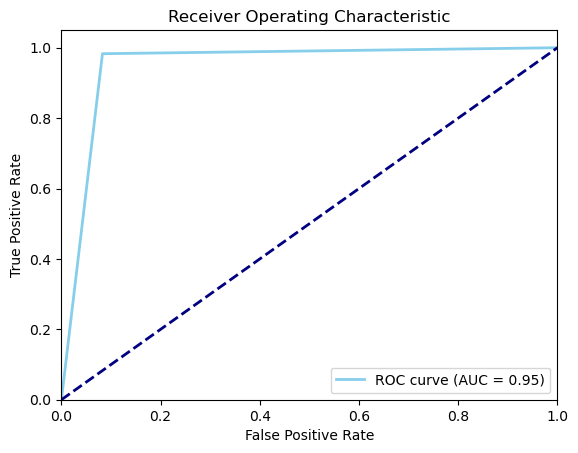

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Numerical data: ['age', 'avg_glucose_level', 'bmi']
Categorical data: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Number transactions X_train dataset:  (7777, 10)
Number transactions y_train dataset:  (7777,)
Number transactions X_test dataset:  (1945, 10)
Number transactions y_test dataset:  (1945,)
After OverSampling, the shape o

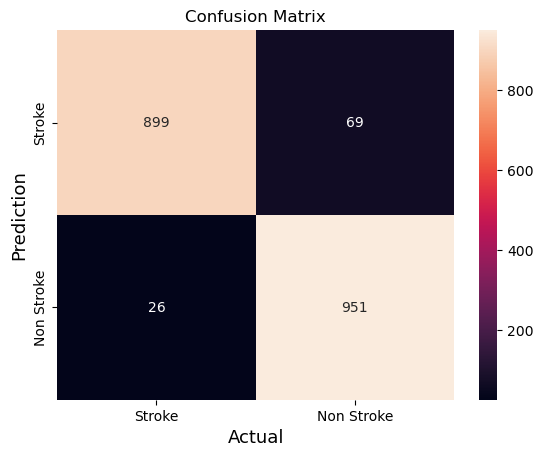

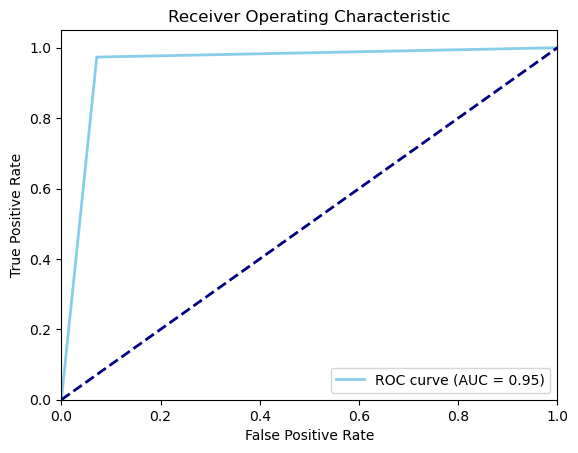

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import pandas as pd 
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, roc_curve, auc

from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA



# Load the stroke dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

 # Check for missing values in the dataset
print(df.isnull().sum())

# Create a copy of the dataset to store interpolated values
df_interp = df.copy()

# Iterate over columns in the dataset
for col in df.columns:
    # Find indices where values are missing
    missing = df[col].isnull()
    
    if missing.sum() > 0:
        # Create an interpolation function
        f = interp1d(df[col][~missing].index, df[col][~missing].values, kind='cubic')
        
        # Use the interpolation function to fill in missing values
        df_interp.loc[missing, col] = f(df[col][missing].index)
        
# Check for missing values in the interpolated dataset
print(df_interp.isnull().sum())


df_interp.drop('id',axis= 1,inplace= True)

numeric_data=df_interp.loc[:,df_interp.nunique() > 5]
cols = [col for col in df_interp.columns if col not in numeric_data]
categorical_data=df_interp[cols].drop('stroke',axis=1)
numeric_data=pd.DataFrame(numeric_data)
categorical_data=pd.DataFrame(categorical_data)
print(f'Numerical data: {list(numeric_data)}')
print(f'Categorical data: {list(categorical_data)}')


#sstandardization

num_cols=numeric_data.columns.to_list()
sc = StandardScaler()
df_interp[num_cols] = sc.fit_transform(df_interp[num_cols])

#df_interp.head()

#label encoding

le = LabelEncoder()
object_col = [col for col in df_interp.columns if df_interp[col].dtype == 'object']
for col in object_col:
    df_interp[col] = le.fit_transform(df_interp[col])

# Separate features and labels
X = df_interp.drop('stroke', axis=1).values
y = df_interp['stroke'].values

# Apply SMOTE to the training set
sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X,y.ravel())

X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled,test_size=0.20)

#Apply PCA
n_components =7 # Choose the number of components based on your analysis
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print('After OverSampling, the shape of train_X: {}'.format(X_train_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resampled.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_resampled == 0)))





#stack based classifier: base- Random forest, Gradient boosting and Meta-KNN

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the base classifiers
rf_classifier.fit(X_train_pca, y_train)
xgb_classifier.fit(X_train_pca, y_train)

# Generate predictions from base classifiers
rf_pred = rf_classifier.predict(X_train_pca)
gb_pred = xgb_classifier.predict(X_train_pca) 

# Create a new feature matrix containing predictions of base classifiers
X_train_stacked = pd.DataFrame({'RF_Pred': rf_pred, 'GB_Pred': gb_pred})

# Define a meta-classifier (e.g., Logistic Regression)
meta_classifier = DecisionTreeClassifier()

# Train the meta-classifier using the stacked features
meta_classifier.fit(X_train_stacked, y_train)

# Generate predictions from base classifiers on the test set
rf_pred_test = rf_classifier.predict(X_test_pca)
gb_pred_test = xgb_classifier.predict(X_test_pca)

# Create a new feature matrix containing predictions of base classifiers for the test set
X_test_stacked = pd.DataFrame({'RF_Pred': rf_pred_test, 'GB_Pred': gb_pred_test})

y_pred = meta_classifier.predict(X_test_stacked)

# print classification report
print(classification_report(y_test, y_pred))

# compute the confusion matrix
cm1 = confusion_matrix(y_test,y_pred)

#Plot the confusion matrix.
sns.heatmap(cm1,
			annot=True,
			fmt='g',
			xticklabels=['Stroke', 'Non Stroke'],
			yticklabels=['Stroke', 'Non Stroke'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='SKYBLUE', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
X_train_pca

array([[-0.67464044,  0.06465383,  1.37947861, ...,  0.98512759,
        -0.41117774,  0.24798107],
       [ 0.05300804, -0.53775095, -1.58849892, ..., -0.16757148,
        -0.33933767,  0.73124244],
       [ 0.75748098,  0.421677  ,  0.5866709 , ..., -0.22301752,
        -0.33666915,  0.72887514],
       ...,
       [-1.85634738,  0.29114943,  1.07875249, ..., -0.34516909,
        -0.55422207, -0.25624631],
       [ 1.57200494,  0.46956767, -0.57652665, ...,  0.0728945 ,
         0.38636719, -0.62175957],
       [ 0.27395628, -2.70468397,  0.18368315, ..., -0.59166439,
         0.4331062 , -0.36918304]])

In [10]:
y_pred 

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [11]:
cm1 

array([[899,  69],
       [ 26, 951]], dtype=int64)

AttributeError: 'DataFrame' object has no attribute 'data'

ValueError: Must pass 2-d input. shape=()

<Figure size 500x700 with 0 Axes>